# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [2]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [3]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [5]:
data = pd.read_csv("../data/BTCUSD_4hours.csv")

data = data.drop(columns="Unnamed: 0").set_index("date")
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [6]:
## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

add_ema(data)

def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



rsi = computeRSI(data)

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

stoch_rsi(rsi)

def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

add_stoch_rsi(data)

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

prices = data["log_close"]

get_bollinger_bands(prices, rate=20)

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

add_bollinger(data,prices)

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

add_vol_roc(data)
data.head(3)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.39,4.390000,4.39,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,1.479329,...,1.479329,1.479329,1.479329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 16:00:00,4.49,4.513333,4.49,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,1.494235,...,1.493363,1.493493,1.493338,NaN,NaN,NaN,NaN,NaN,NaN,68.40758
2012-01-01 04:00:00,4.58,4.580000,4.58,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,1.504954,...,1.503189,1.503453,1.503138,NaN,NaN,NaN,NaN,NaN,NaN,-0.95250


### Daily return

$ return = \frac{new - old}{old} $

In [7]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [8]:
data = data.dropna()

## Time-Series Visualisation

### Historical Stock Prices

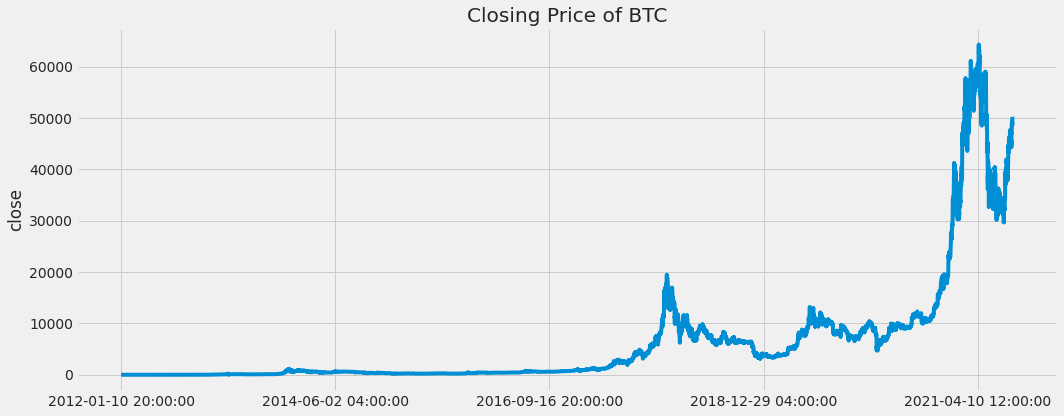

In [7]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of {coin_selection}")
    
plt.tight_layout()

### Volumes traded

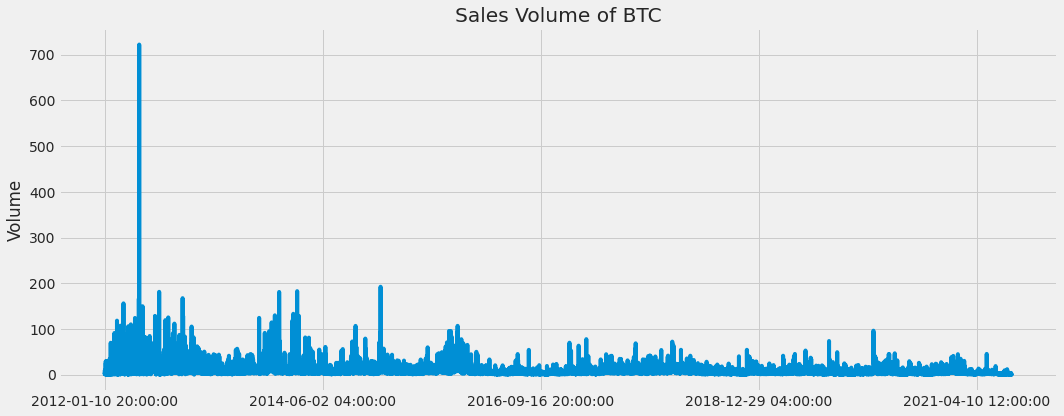

In [8]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

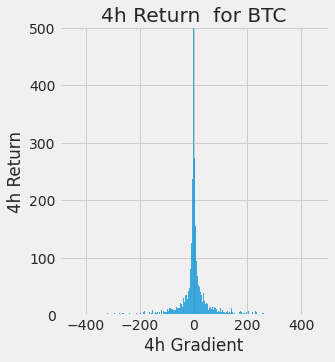

In [10]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for {coin_selection}");

# SELECT FEATURES

In [9]:
## get only the close data
selected_features=["log_close"]
selected_data = data[selected_features]
selected_data.sample(10)

,log_close
date,
2016-07-04 12:00:00,6.507999
2021-05-14 04:00:00,10.809108
2016-05-01 20:00:00,6.113058
2018-05-16 20:00:00,9.023210
2020-11-29 04:00:00,9.786527
2013-02-13 12:00:00,3.243261
2021-06-05 08:00:00,10.517200
2020-03-28 16:00:00,8.734049
2016-02-05 00:00:00,5.961217


## BITCOIN Price

### Temporal Train-Test Split

In [12]:
#train_percentage = 95

In [13]:
#train_len = int(len(selected_data) * train_percentage/100)
#train_len

19768

In [14]:
#data_train = selected_data[:train_len]
#data_test = selected_data[train_len:]

## LSTM

In [15]:
# from sklearn.preprocessing import MinMaxScaler

# minmax_scaler = MinMaxScaler(feature_range = (0,1))

# minmax_scaler.fit(data_train)

# data_train_scaled = pd.DataFrame(minmax_scaler.transform(data_train))
# data_train_scaled.columns = data_train.columns
# data_test_scaled = pd.DataFrame(minmax_scaler.transform(data_test))
# data_test_scaled.columns = data_test.columns

In [16]:
# minmax_scaler.data_max_

array([10.96497341])

In [17]:
# minmax_scaler.data_min_

array([1.44133982])

In [18]:
# data_train_scaled.sample(5)

,log_close
19170,0.879889
13162,0.811019
17301,0.800697
8001,0.434256
5218,0.523869


In [19]:
# data_test_scaled.sample(5)

,log_close
346,0.992779
712,0.950595
789,0.944294
944,0.969925
227,1.000808


### Creating subsequences...

In [20]:
# def subsequence(df, length, horizon):
#     last_possible_start = len(df) - length - horizon
#     random_start = np.random.randint(0, last_possible_start)
#     X = df[random_start:random_start + length]
#     y = df.iloc[random_start + length + horizon]['log_close']
    
#     return X, y

In [21]:
# length = 60
# horizon  = 1

# X_train, y_train = subsequence(data_train, length, horizon)
# y_train

# X_test, y_test = subsequence(data_test, length, horizon)
# y_test

10.982395850308958

**`multiple_subsequences`**

In [22]:
# def multiple_subsequences(df, number_of_subsequences, length ,horizon = 1):
#     list_of_lengths = np.random.randint(66, 72, number_of_subsequences)
#     if not length:
#       list_of_X = [subsequence(df, list_of_lengths[_], horizon)[0] for _ in range(number_of_subsequences)]
#       list_of_y = [subsequence(df, list_of_lengths[_], horizon)[1] for _ in range(number_of_subsequences)] # 
#     else:
#       list_of_X = [subsequence(df, length, horizon)[0] for _ in range(number_of_subsequences)]
#       list_of_y = [subsequence(df, length, horizon)[1] for _ in range(number_of_subsequences)] #       
    
#     return list_of_X, list_of_y

In [23]:
# X_train, y_train = multiple_subsequences(data_train_scaled, 2000, length=None, horizon = 1)
# X_test, y_test = multiple_subsequences(data_test_scaled, 1000, length=None,horizon = 1)

### LSTM

#### Padding...

(array([166.,   0., 178.,   0., 186.,   0., 165.,   0., 160., 145.]),
 array([66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. ]),
 <BarContainer object of 10 artists>)

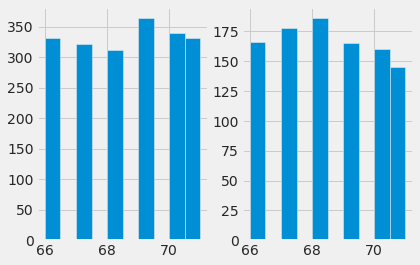

In [24]:
# plt.subplot(1,2,1)
# plt.hist([len(_) for _ in X_train])
# plt.subplot(1,2,2)
# plt.hist([len(_) for _ in X_test])

In [25]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# X_train_pad = pad_sequences(X_train, value = -999, padding = "post", dtype="float64")
# X_test_pad = pad_sequences(X_test, value = -999, padding = "post", dtype="float64")

In [26]:
# X_train_pad.shape, X_test_pad.shape

((2000, 71, 1), (1000, 71, 1))

#### RNN Architecture

In [27]:
# pd.DataFrame(y_test).shape

(1000, 1)

In [16]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


2021-08-26 16:37:09.645985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 16:37:09.646044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-26 16:37:12.074637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-26 16:37:12.074843: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-26 16:37:12.074882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-33CGF2OU): /proc/driver/nvidia/version does not exist
2021-08-26 16:37:12.077182: I tensorflow/core/platform/cpu_fe

In [ ]:
# from tensorflow.keras import Sequential, layers

# # Build the LSTM model
# model = Sequential()
# model.add(layers.Masking(mask_value=-999., input_shape=X_train_pad.shape[1:]))
# model.add(layers.LSTM(units=128,
#                      return_sequences = True,
#                      activation = "tanh",
#                      input_shape = X_train_pad[0].shape))

# model.add(layers.LSTM(units=64,
#                       return_sequences = False,
#                       activation = "tanh"))

# model.add(layers.Dense(25,
#                          activation="relu"))

# model.add(layers.Dense(1,
#                       activation="relu"))

# model.summary()



In [ ]:
# model.compile(loss="mse",
#              optimizer = "rmsprop",
#              metrics = [my_mae])

#### Training

In [ ]:
#### perhaps create a validation and train sets by hand

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping 

# es = EarlyStopping(patience = 5, monitor = "val_mean_absolute_error")

# history = model.fit(X_train_pad, np.array(y_train),
#           validation_split = 0.3,
#          batch_size=16,
#          epochs=5,
#          verbose = 1,
#          callbacks = [es])

In [17]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

In [ ]:
# plot_loss_mae(history)

#### Evaluating

In [ ]:
# res = model.evaluate(X_test_pad, np.array(y_test), verbose = 1)
# res


#### Predictions

In [ ]:
# predictions = model.predict(X_test_pad)


In [ ]:
# len(predictions), len(y_test)

In [ ]:
# predictions[0:3]

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [ ]:
# a = minmax_scaler.data_min_
# b = minmax_scaler.data_max_

In [ ]:
# unscaled_predictions = predictions * (b - a) + a
# unscaled_predictions[:3]
# # len is 1000

In [ ]:
# unscaled_predictions = minmax_scaler.inverse_transform(predictions)
# unscaled_predictions[:3]

In [ ]:
# unscaled_y_test = minmax_scaler.inverse_transform(np.array([y_test])).T
# unscaled_y_test[:3]

In [ ]:
# unscaled_y_test  = np.array(y_test)*(b - a) + a
# unscaled_y_test[:3]

In [ ]:
# unscaled_predictions.shape

In [ ]:
# unscaled_y_test.shape

In [ ]:
# #MAE
# np.mean(np.abs(unscaled_y_test - unscaled_predictions))

In [ ]:
# np.exp(np.mean(np.abs(unscaled_y_test - unscaled_predictions)))

In [ ]:
# #MSE
# np.sqrt(np.mean((unscaled_y_test - unscaled_predictions)**2))

In [ ]:
# X_train_pad.shape

In [ ]:
# predictions_train = model.predict(X_train_pad)
# unscaled_predictions_train = minmax_scaler.inverse_transform(predictions_train)
# unscaled_y_train = minmax_scaler.inverse_transform(np.array([y_train])).T
# np.mean(np.abs(unscaled_y_train - unscaled_predictions_train))

## Second round

In [18]:
dataset = data[["log_close"]].values
dataset

array([[ 1.96571278],
       [ 1.94982026],
       [ 1.97487604],
       ...,
       [10.79566039],
       [10.81540794],
       [10.82531108]])

In [19]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.05444881],
       [0.0527986 ],
       [0.05540029],
       ...,
       [0.9713156 ],
       [0.97336611],
       [0.97439441]])

In [20]:
length = 60
horizon  = 1

training_split = 0.85
training_data_length = int(np.ceil(len(dataset) * training_split))
training_data_length

17688

In [21]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
y_train = []

x_train = [train_data[i-length:i, 0] for i in range(length, len(train_data))]
y_train = [train_data[i, 0] for i in range(length, len(train_data))]
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [22]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - length: , :]
# Create the data sets x_test and y_test

y_test = dataset[training_data_length:, :]
x_test = [test_data[i-length:i, 0] for i in range(length, len(test_data))]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [23]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17628, 60, 1) (17628,)
(3121, 60, 1) (3121, 1)


In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = my_mae)

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=1, validation_split = 0.4)

2021-08-26 16:38:35.207925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1322/1322 [==============================] - 87s 64ms/step - loss: 4.1118e-04 - mean_absolute_error: 0.0064 - val_loss: 1.1202e-04 - val_mean_absolute_error: 0.0095


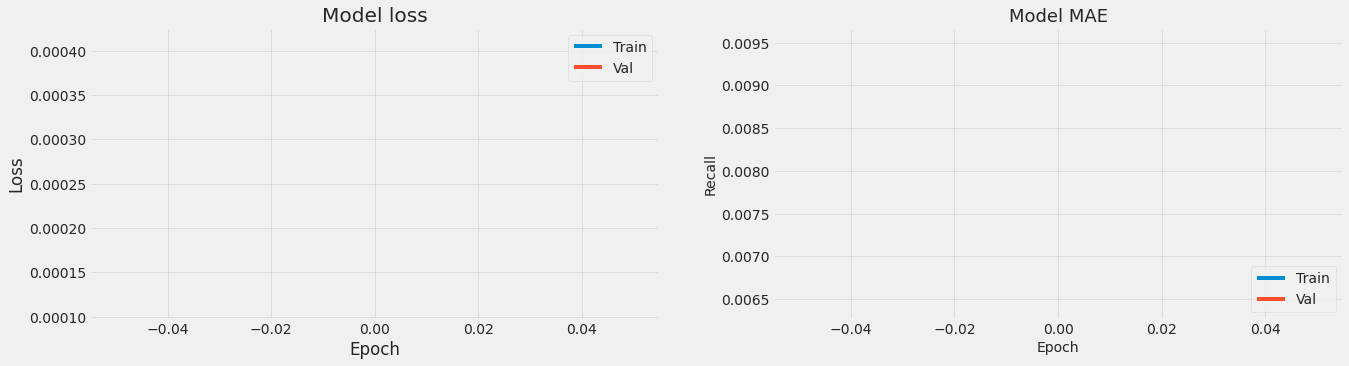

In [25]:
plot_loss_mae(history)

In [26]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[:3]

array([[8.627505],
       [8.634287],
       [8.638061]], dtype=float32)

In [27]:
y_test.shape, predictions.shape

((3121, 1), (3121, 1))

In [28]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

0.19682405195591807

In [29]:
model.evaluate(x_test, y_test)

98/98 [==============================] - 2s 20ms/step - loss: 82.5991 - mean_absolute_error: 9.0641


[82.59908294677734, 9.064098358154297]

In [30]:
# Plot the data
train = selected_data[:training_data_length]
valid = selected_data[training_data_length:].copy()

In [31]:
train

,log_close
date,
2012-01-10 20:00:00,1.965713
2012-01-11 08:00:00,1.949820
2012-01-11 12:00:00,1.974876
2012-01-11 16:00:00,1.938716
2012-01-11 20:00:00,1.945910
...,...
2020-03-20 08:00:00,8.790315
2020-03-20 12:00:00,8.800320
2020-03-20 16:00:00,8.771752


In [32]:
valid

,log_close
date,
2020-03-21 04:00:00,8.729720
2020-03-21 08:00:00,8.711371
2020-03-21 12:00:00,8.720647
2020-03-21 16:00:00,8.726979
2020-03-21 20:00:00,8.740591
...,...
2021-08-22 12:00:00,10.794853
2021-08-22 16:00:00,10.791202
2021-08-22 20:00:00,10.795660


In [33]:
valid["Predictions"] = predictions
valid

,log_close,Predictions
date,,
2020-03-21 04:00:00,8.729720,8.627505
2020-03-21 08:00:00,8.711371,8.634287
2020-03-21 12:00:00,8.720647,8.638061
2020-03-21 16:00:00,8.726979,8.639996
2020-03-21 20:00:00,8.740591,8.640892
...,...,...
2021-08-22 12:00:00,10.794853,10.539631
2021-08-22 16:00:00,10.791202,10.541185
2021-08-22 20:00:00,10.795660,10.541955


In [34]:
valid['close'] = valid.log_close.apply(lambda x: np.exp(x))
valid['pred'] = valid.Predictions.apply(lambda x: np.exp(x))

In [35]:
valid['diff'] = valid.log_close - valid.Predictions

In [36]:
valid

,log_close,Predictions,close,pred,diff
date,,,,,
2020-03-21 04:00:00,8.729720,8.627505,6183.993348,5583.132638,0.102214
2020-03-21 08:00:00,8.711371,8.634287,6071.563509,5621.123762,0.077085
2020-03-21 12:00:00,8.720647,8.638061,6128.139695,5642.376211,0.082586
2020-03-21 16:00:00,8.726979,8.639996,6167.069381,5653.304808,0.086983
2020-03-21 20:00:00,8.740591,8.640892,6251.586634,5658.375007,0.099699
...,...,...,...,...,...
2021-08-22 12:00:00,10.794853,10.539631,48769.127815,37783.617564,0.255222
2021-08-22 16:00:00,10.791202,10.541185,48591.428238,37842.397462,0.250017
2021-08-22 20:00:00,10.795660,10.541955,48808.530953,37871.532755,0.253705


In [37]:
weight = valid['diff'].mean()

In [38]:
valid.index = pd.to_datetime(valid.index, format = "%Y-%m-%d %H:%M:%S")
train.index = pd.to_datetime(train.index, format = "%Y-%m-%d %H:%M:%S")

In [39]:
import datetime

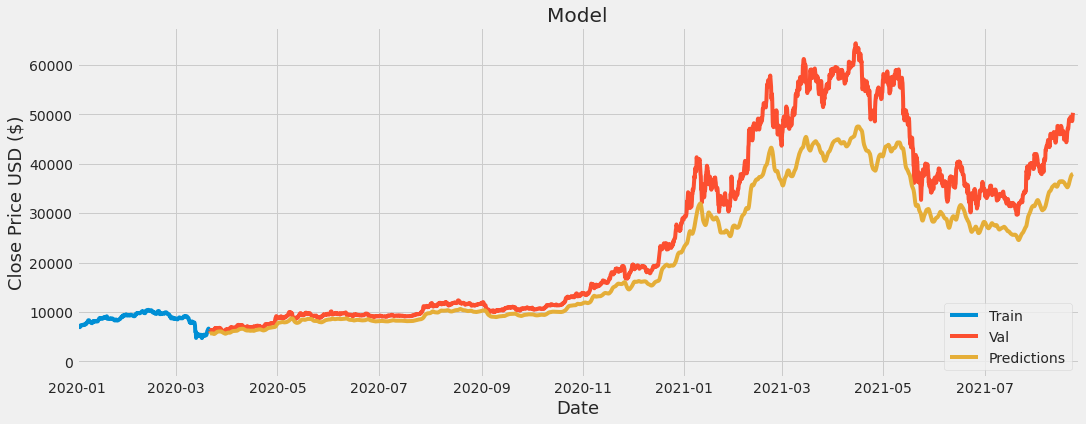

In [40]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.plot(train['log_close'].apply(lambda x: np.exp(x)))
plt.plot(valid[['close', 'pred']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xlim([datetime.date(2020, 1, 1), datetime.datetime.now()])
plt.show()

In [41]:
import requests

In [42]:
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

In [43]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [44]:
coingecko = feature_engineer(get_coingecko())

In [45]:
coingecko

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
2021-07-27 16:00:00,38147.61,38147.61,38147.61,38147.61,4.367997e+10,10.549218,10.549218,10.549218,10.549218,10.549218,...,10.549218,10.549218,10.549218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-27 20:00:00,38195.58,38195.58,37691.22,38001.27,3.785827e+10,10.550475,10.550475,10.537182,10.545375,10.547136,...,10.547258,10.547240,10.547262,NaN,NaN,NaN,NaN,NaN,NaN,-0.133281
2021-07-28 00:00:00,38056.91,39265.54,38056.91,39265.54,3.711797e+10,10.546838,10.578103,10.546838,10.578103,10.559223,...,10.557954,10.558138,10.557918,NaN,NaN,NaN,NaN,NaN,NaN,-0.019554
2021-07-28 04:00:00,39076.59,39891.52,39076.59,39891.52,3.908520e+10,10.573279,10.593919,10.573279,10.593919,10.570175,...,10.567491,10.567888,10.567415,NaN,NaN,NaN,NaN,NaN,NaN,0.052999
2021-07-28 08:00:00,39731.45,40065.84,39377.93,39377.93,4.038366e+10,10.589898,10.598279,10.580961,10.580961,10.573105,...,10.570405,10.570819,10.570325,NaN,NaN,NaN,NaN,NaN,NaN,0.033221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25 20:00:00,48742.86,48995.85,48714.42,48922.71,3.333321e+10,10.794314,10.799491,10.793730,10.797997,10.792144,...,10.779335,10.787805,10.776580,53.173343,32.994443,18.860284,10.799351,10.829016,10.769685,-0.025343
2021-08-26 00:00:00,48753.77,48942.77,48701.72,48876.83,3.341253e+10,10.794538,10.798407,10.793470,10.797059,10.792900,...,10.780030,10.788333,10.777313,52.730341,53.336844,34.277539,10.799782,10.829026,10.770538,0.002380
2021-08-26 04:00:00,48989.51,49320.14,48720.92,48720.92,3.413287e+10,10.799361,10.806088,10.793864,10.793864,10.793048,...,10.780573,10.788649,10.777905,51.167069,59.268942,48.533410,10.800016,10.828977,10.771056,0.021559
2021-08-26 08:00:00,47962.35,47962.35,46991.39,46991.39,3.632926e+10,10.778172,10.778172,10.757720,10.757720,10.787613,...,10.779676,10.786882,10.777183,37.590047,38.231251,50.279012,10.797803,10.832357,10.763250,0.064348


In [46]:
x_gecko = coingecko[['log_close']][-60:]

In [47]:
x_gecko

,log_close
2021-08-16 16:00:00,10.740039
2021-08-16 20:00:00,10.745549
2021-08-17 00:00:00,10.741696
2021-08-17 04:00:00,10.745477
2021-08-17 08:00:00,10.732901
2021-08-17 12:00:00,10.753188
2021-08-17 16:00:00,10.736574
2021-08-17 20:00:00,10.730079
2021-08-18 00:00:00,10.713024
2021-08-18 04:00:00,10.713388


In [48]:
#pd.DataFrame(x_gecko).iloc[61]

In [49]:
x_gecko_scaled = scaler.transform(x_gecko)

In [50]:
x_gecko.shape

(60, 1)

In [51]:
x_gecko = np.array(x_gecko_scaled)
x_gecko = np.reshape(x_gecko, (1,60,1))

In [52]:
x_gecko.shape

(1, 60, 1)

In [53]:
x_gecko

array([[[0.96554004],
        [0.96611225],
        [0.96571211],
        [0.96610476],
        [0.96479891],
        [0.96690545],
        [0.96518035],
        [0.96450593],
        [0.96273493],
        [0.96277273],
        [0.96392867],
        [0.96378592],
        [0.96365967],
        [0.96406653],
        [0.96240961],
        [0.96213524],
        [0.96154981],
        [0.96155939],
        [0.96371455],
        [0.96659505],
        [0.9664196 ],
        [0.96775899],
        [0.96747299],
        [0.96769493],
        [0.97072034],
        [0.97048238],
        [0.97198533],
        [0.9714082 ],
        [0.97100018],
        [0.9718757 ],
        [0.97173036],
        [0.97286577],
        [0.97249243],
        [0.9714061 ],
        [0.97222452],
        [0.97225723],
        [0.97056463],
        [0.97064286],
        [0.97197117],
        [0.97392439],
        [0.97402428],
        [0.97398608],
        [0.9727682 ],
        [0.97284432],
        [0.9730318 ],
        [0

In [54]:
predictions = model.predict(x_gecko)
predictions = scaler.inverse_transform(predictions)

In [55]:
predictions

array([[10.532594]], dtype=float32)

In [56]:
weight

0.18461147529322264

In [57]:
np.exp(weight + predictions)

array([[45125.6]], dtype=float32)